In [ ]:
# !pip install setuptools==61.0.0 pyts mlflow plum-dispatch==1.7.2 torchdiffeq
# !pip install git+https://github.com/pnnl/neuromancer.git@master --ignore-requires-python --no-deps
# Uncomment pip installs for Colab notebook    

# Control 

## Typical scenario. Off policy control learning

In a typical real world control setting, due to cost and operational concerns, there is not an opportunity to directly interact with the system to learn a controller. In this scenario, the system is perturbed for some amount of time to collect measurements representative of the system state space, system identification is performed, and a controller is created based on the fitted model created via system identification. In the following cells we walk through the three stage process of generating data, system identification, and control policy learning using neuromancer. 

## Generate a representative of system behavior

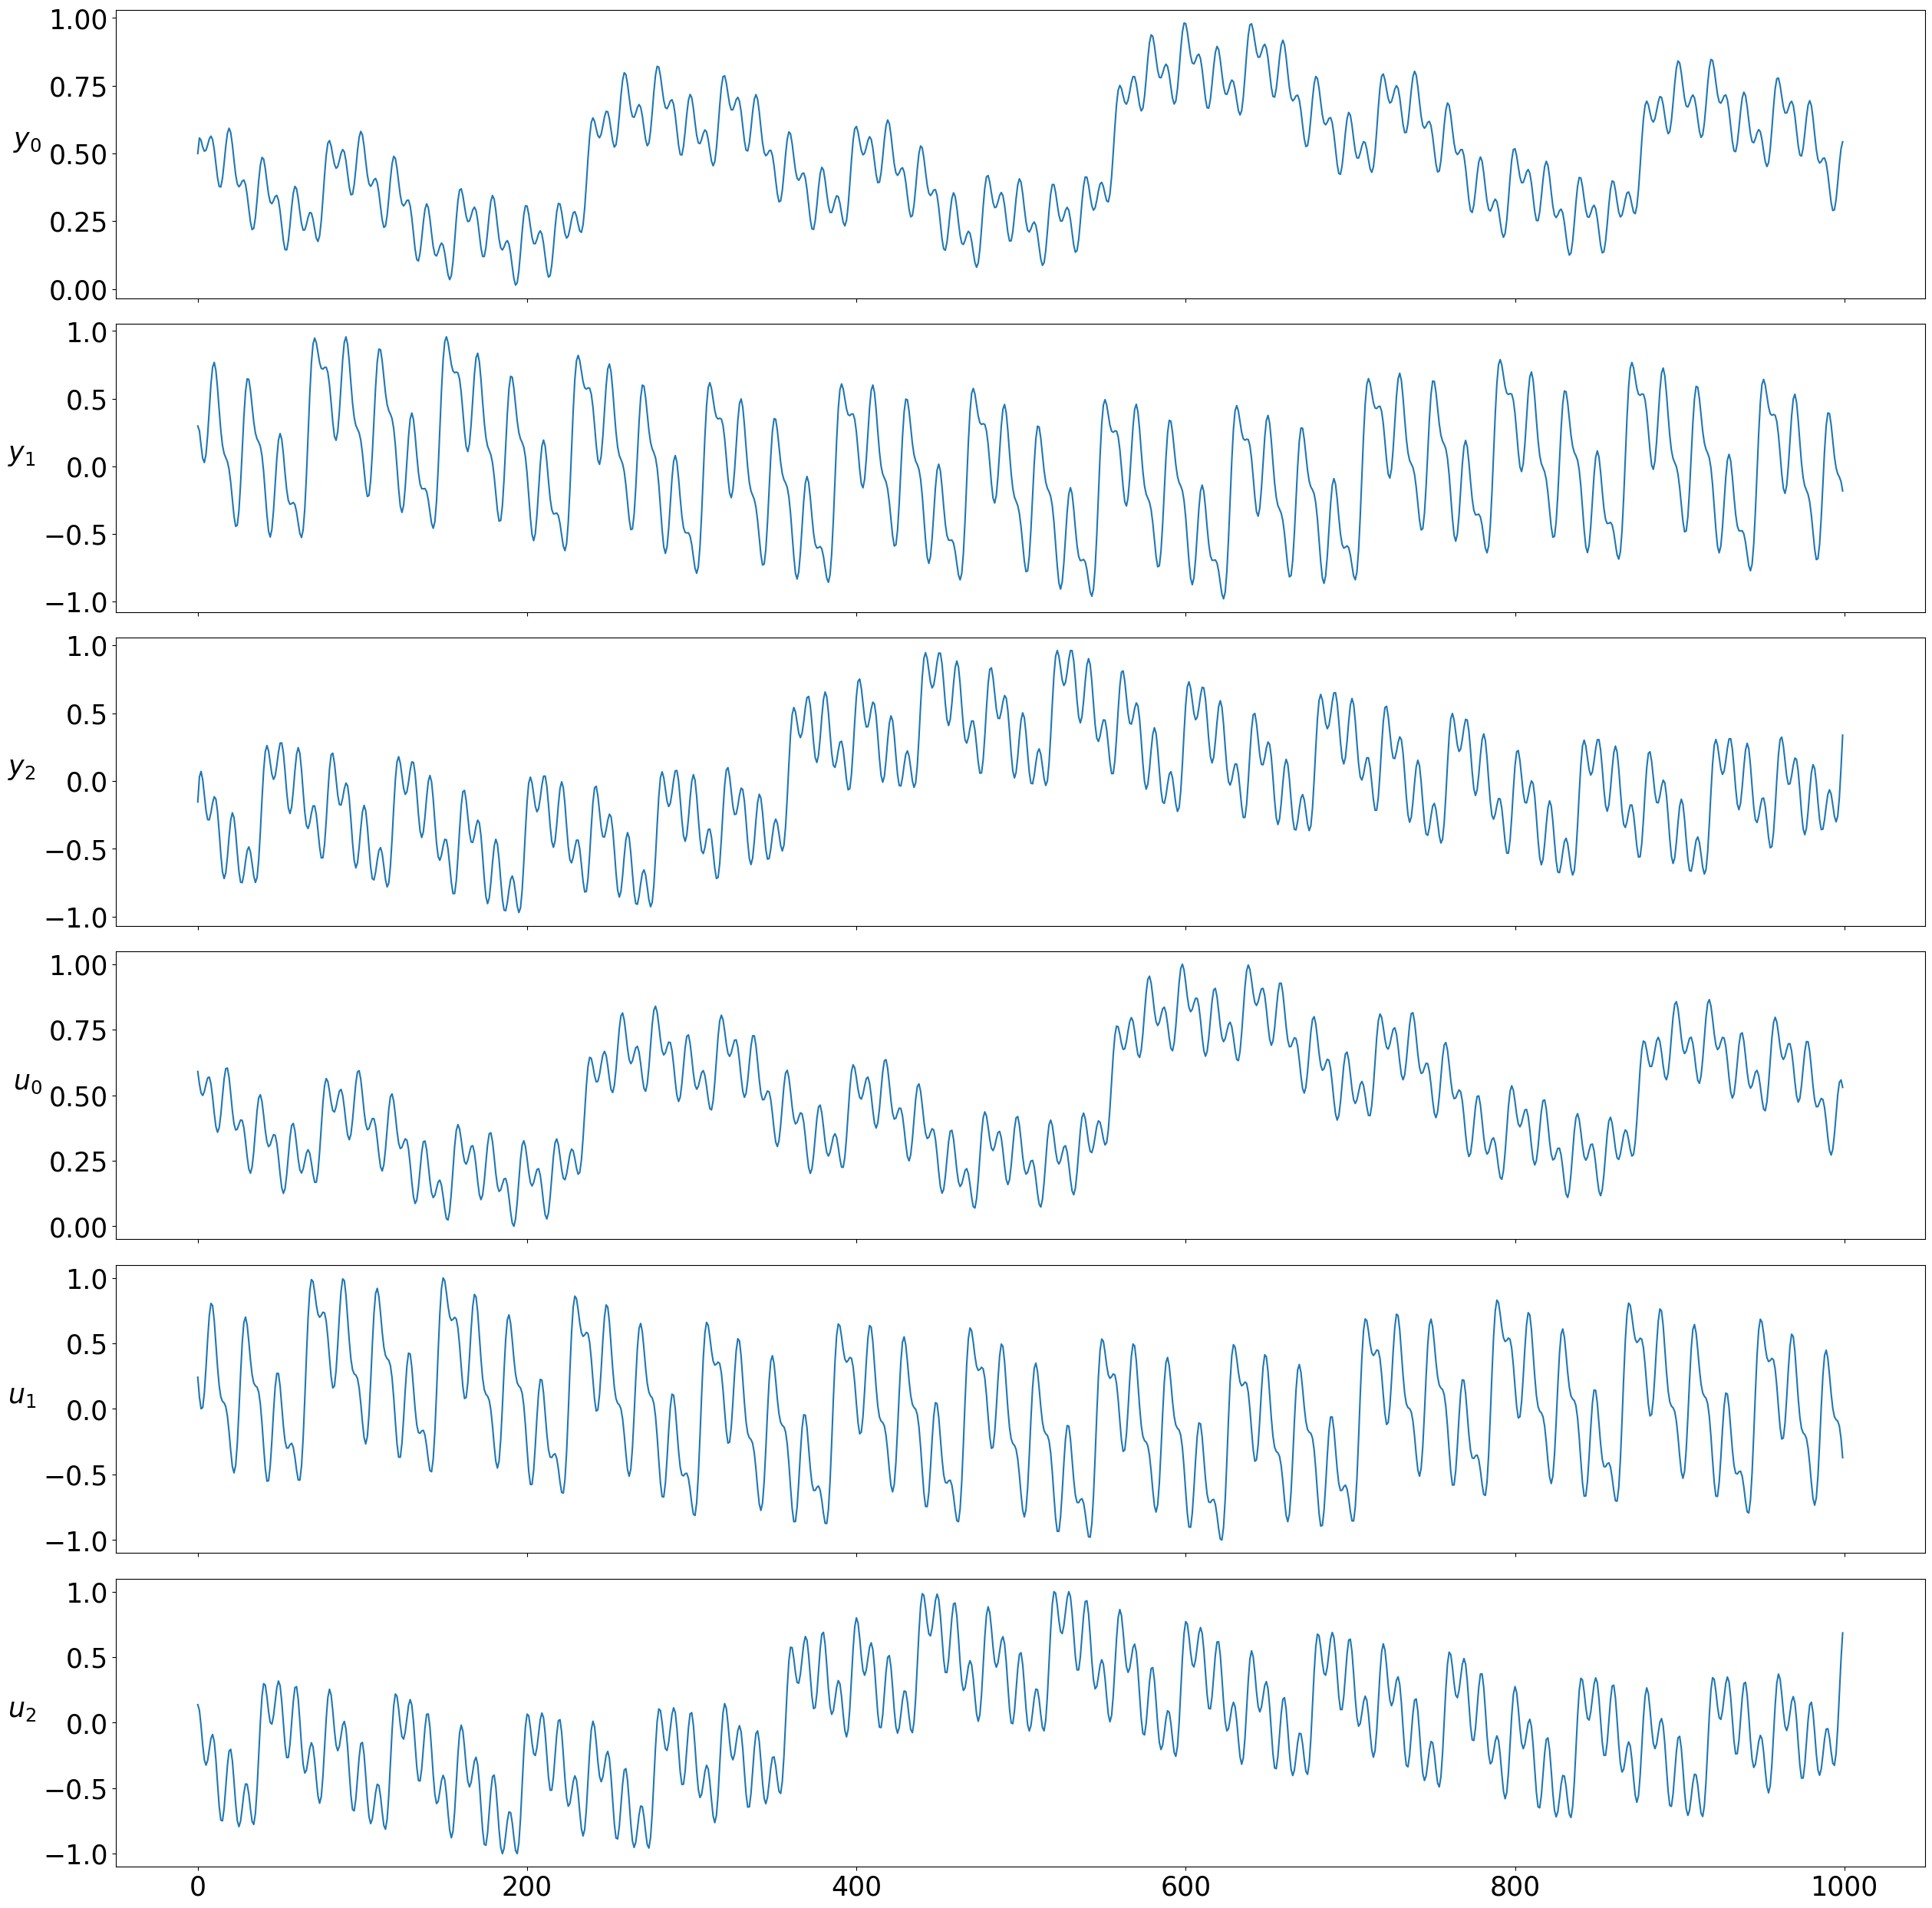

In [1]:
from neuromancer.psl.nonautonomous import Actuator
from neuromancer.dataset import DictDataset
sys = Actuator()

train_data, dev_data, test_data = [sys.simulate(nsim=1000) for i in range(3)]
sys.show(train_data)

from torch.utils.data import DataLoader
train_data, dev_data, test_data = [sys.normalize(d) for d in [train_data, dev_data, test_data]]
for d in [train_data, dev_data]:
    d['X'] = d['X'].reshape(100, 10, 3)
    d['U'] = d['U'].reshape(100, 10, 3)
    d['Y'] = d['Y'].reshape(100, 10, 3)
    d['xn'] = d['X'][:, 0:1, :]
    d['Time'] = d['Time'].reshape(100, -1)
train_dataset, dev_dataset, = [DictDataset(d, name=n) for d, n in zip([train_data, dev_data], ['train', 'dev'])]
train_loader, dev_loader, test_loader = [DataLoader(d, batch_size=100, collate_fn=d.collate_fn, shuffle=True) for d in [train_dataset, dev_dataset, dev_dataset]]


# Define a simple neural ODE model of the system

In [14]:
from neuromancer.system import Node, System
from neuromancer.modules import blocks
from neuromancer.dynamics import integrators
import torch

dx = blocks.MLP(sys.nx + sys.nu, sys.nx, bias=True, linear_map=torch.nn.Linear, nonlin=torch.nn.ELU,
              hsizes=[20 for h in range(3)])
interp_u = lambda tq, t, u: u
integrator = integrators.Euler(dx, h=torch.tensor(0.1), interp_u=interp_u)
system_node = Node(integrator, ['xn', 'U'], ['xn'])
model = System([system_node])
# model.show()

# Define the optimization problem

In [15]:
from neuromancer.constraint import variable
from neuromancer.problem import Problem
from neuromancer.loss import PenaltyLoss

# Nstep rollout predictions from the model
xpred = variable('xn')[:, :-1, :]
# Ground truth data
xtrue = variable('X')

loss = (xpred == xtrue) ^ 2
loss.update_name('loss')

obj = PenaltyLoss([loss], [])
problem = Problem([model], obj)

## Minimize the system identification problem

In [17]:
from neuromancer.trainer import Trainer
import torch.optim as optim

opt = optim.Adam(model.parameters(), 0.001)
trainer = Trainer(problem, train_loader, dev_loader, test_loader, opt,
                  epochs=1000,
                  patience=300,
                  train_metric='train_loss',
                  dev_metric='dev_loss',
                  test_metric='test_loss',
                  eval_metric='dev_loss')
best_model = trainer.train()

epoch: 0  train_loss: 0.5117571353912354
epoch: 1  train_loss: 0.5060186982154846
epoch: 2  train_loss: 0.50039142370224
epoch: 3  train_loss: 0.49487003684043884
epoch: 4  train_loss: 0.48945093154907227
epoch: 5  train_loss: 0.48412981629371643
epoch: 6  train_loss: 0.47890135645866394
epoch: 7  train_loss: 0.4737601578235626
epoch: 8  train_loss: 0.4687005281448364
epoch: 9  train_loss: 0.46371763944625854
epoch: 10  train_loss: 0.4588072597980499
epoch: 11  train_loss: 0.4539658725261688
epoch: 12  train_loss: 0.4491903781890869
epoch: 13  train_loss: 0.4444786310195923
epoch: 14  train_loss: 0.439828485250473
epoch: 15  train_loss: 0.43523821234703064
epoch: 16  train_loss: 0.4307065010070801
epoch: 17  train_loss: 0.42623212933540344
epoch: 18  train_loss: 0.4218142628669739
epoch: 19  train_loss: 0.4174523949623108
epoch: 20  train_loss: 0.4131465256214142
epoch: 21  train_loss: 0.4088969826698303
epoch: 22  train_loss: 0.4047042727470398
epoch: 23  train_loss: 0.400569587945938

epoch: 202  train_loss: 0.043983206152915955
epoch: 203  train_loss: 0.04341677203774452
epoch: 204  train_loss: 0.04286551475524902
epoch: 205  train_loss: 0.0423290878534317
epoch: 206  train_loss: 0.04180712252855301
epoch: 207  train_loss: 0.04129926115274429
epoch: 208  train_loss: 0.04080510884523392
epoch: 209  train_loss: 0.040324240922927856
epoch: 210  train_loss: 0.039856236428022385
epoch: 211  train_loss: 0.03940065950155258
epoch: 212  train_loss: 0.03895706310868263
epoch: 213  train_loss: 0.03852499648928642
epoch: 214  train_loss: 0.038103993982076645
epoch: 215  train_loss: 0.03769359737634659
epoch: 216  train_loss: 0.03729334846138954
epoch: 217  train_loss: 0.0369027704000473
epoch: 218  train_loss: 0.03652140870690346
epoch: 219  train_loss: 0.0361488051712513
epoch: 220  train_loss: 0.03578450158238411
epoch: 221  train_loss: 0.03542805090546608
epoch: 222  train_loss: 0.03507900983095169
epoch: 223  train_loss: 0.03473695367574692
epoch: 224  train_loss: 0.03440

epoch: 390  train_loss: 0.0019947290420532227
epoch: 391  train_loss: 0.0019548137206584215
epoch: 392  train_loss: 0.0019159771036356688
epoch: 393  train_loss: 0.0018781949765980244
epoch: 394  train_loss: 0.00184144068043679
epoch: 395  train_loss: 0.0018056901171803474
epoch: 396  train_loss: 0.0017709187231957912
epoch: 397  train_loss: 0.001737101818434894
epoch: 398  train_loss: 0.0017042163526639342
epoch: 399  train_loss: 0.0016722386935725808
epoch: 400  train_loss: 0.0016411461401730776
epoch: 401  train_loss: 0.0016109161078929901
epoch: 402  train_loss: 0.0015815262449905276
epoch: 403  train_loss: 0.0015529547818005085
epoch: 404  train_loss: 0.001525180647149682
epoch: 405  train_loss: 0.001498183235526085
epoch: 406  train_loss: 0.0014719420578330755
epoch: 407  train_loss: 0.0014464372070506215
epoch: 408  train_loss: 0.0014216481940820813
epoch: 409  train_loss: 0.0013975562760606408
epoch: 410  train_loss: 0.0013741424772888422
epoch: 411  train_loss: 0.0013513892190

epoch: 572  train_loss: 0.000494046020321548
epoch: 573  train_loss: 0.0004929389688186347
epoch: 574  train_loss: 0.0004918386694043875
epoch: 575  train_loss: 0.000490745238494128
epoch: 576  train_loss: 0.0004896580940112472
epoch: 577  train_loss: 0.0004885775269940495
epoch: 578  train_loss: 0.0004875031590927392
epoch: 579  train_loss: 0.0004864348447881639
epoch: 580  train_loss: 0.0004853729042224586
epoch: 581  train_loss: 0.0004843167553190142
epoch: 582  train_loss: 0.00048326648538932204
epoch: 583  train_loss: 0.0004822221235372126
epoch: 584  train_loss: 0.0004811835242435336
epoch: 585  train_loss: 0.00048015033826231956
epoch: 586  train_loss: 0.00047912276932038367
epoch: 587  train_loss: 0.0004781006136909127
epoch: 588  train_loss: 0.0004770838131662458
epoch: 589  train_loss: 0.0004760721931234002
epoch: 590  train_loss: 0.0004750659572891891
epoch: 591  train_loss: 0.0004740646982099861
epoch: 592  train_loss: 0.00047306870692409575
epoch: 593  train_loss: 0.000472

epoch: 759  train_loss: 0.0003506584616843611
epoch: 760  train_loss: 0.0003501074679661542
epoch: 761  train_loss: 0.0003495581040624529
epoch: 762  train_loss: 0.00034901031176559627
epoch: 763  train_loss: 0.0003484640910755843
epoch: 764  train_loss: 0.00034791967482306063
epoch: 765  train_loss: 0.000347376597346738
epoch: 766  train_loss: 0.00034683517878875136
epoch: 767  train_loss: 0.0003462951281107962
epoch: 768  train_loss: 0.0003457569982856512
epoch: 769  train_loss: 0.00034522011992521584
epoch: 770  train_loss: 0.0003446850460022688
epoch: 771  train_loss: 0.00034415116533637047
epoch: 772  train_loss: 0.0003436191182117909
epoch: 773  train_loss: 0.0003430884680710733
epoch: 774  train_loss: 0.00034255930222570896
epoch: 775  train_loss: 0.00034203167888335884
epoch: 776  train_loss: 0.000341505539836362
epoch: 777  train_loss: 0.00034098088508471847
epoch: 778  train_loss: 0.0003404578019399196
epoch: 779  train_loss: 0.0003399362612981349
epoch: 780  train_loss: 0.00

epoch: 941  train_loss: 0.00027143635088577867
epoch: 942  train_loss: 0.0002710937988013029
epoch: 943  train_loss: 0.00027075206162407994
epoch: 944  train_loss: 0.00027041113935410976
epoch: 945  train_loss: 0.0002700710028875619
epoch: 946  train_loss: 0.00026973156491294503
epoch: 947  train_loss: 0.0002693930291570723
epoch: 948  train_loss: 0.0002690551627893001
epoch: 949  train_loss: 0.00026871805312111974
epoch: 950  train_loss: 0.00026838190387934446
epoch: 951  train_loss: 0.00026804645312950015
epoch: 952  train_loss: 0.0002677116426639259
epoch: 953  train_loss: 0.0002673777344170958
epoch: 954  train_loss: 0.00026704464107751846
epoch: 955  train_loss: 0.0002667121880222112
epoch: 956  train_loss: 0.00026638052077032626
epoch: 957  train_loss: 0.0002660496102180332
epoch: 958  train_loss: 0.0002657196018844843
epoch: 959  train_loss: 0.000265390204731375
epoch: 960  train_loss: 0.0002650615351740271
epoch: 961  train_loss: 0.00026473362231627107
epoch: 962  train_loss: 0

## Evaluate system model on 1000 time step rollout

{'Y': (1000, 3), 'X': (1000, 3), 'U': (1000, 3), 'Time': (1000,)}


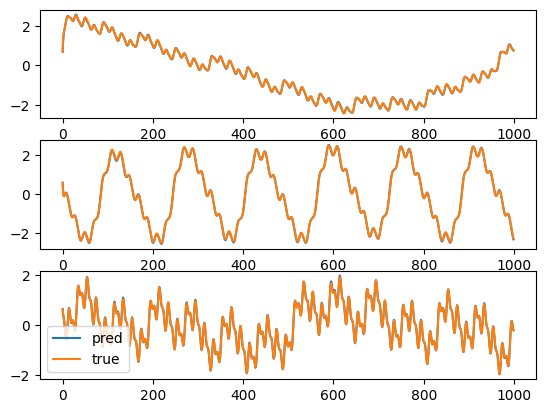

In [18]:
import torch
test_data = sys.normalize(sys.simulate(nsim=1000))
print({k: v.shape for k, v in test_data.items()})

test_data['X'] = test_data['X'].reshape(1, *test_data['X'].shape)
test_data['U'] = test_data['U'].reshape(1, *test_data['U'].shape)
test_data['xn'] = test_data['X'][:, 0:1, :]
test_data = {k: torch.tensor(v, dtype=torch.float32) for k, v in test_data.items()}
test_output = model(test_data)

import matplotlib.pyplot as plt
fix, ax = plt.subplots(nrows=3)
for v in range(3):
    ax[v].plot(test_output['xn'][0, :-1, v].detach().numpy(), label='pred')
    ax[v].plot(test_data['X'][0, :, v].detach().numpy(), label='true')
plt.legend()

## Create a closed loop system using the system model and a parametrized control policy


In [21]:
nx, nu = sys.nx, sys.nu

class Policy(torch.nn.Module):

    def __init__(self, insize, outsize):
        super().__init__()
        self.net = blocks.MLP(insize, outsize, bias=True, hsizes=[20, 20, 20])

    def forward(self, x, R):
        features = torch.cat([x, R], dim=-1)
        return self.net(features)

insize = 2*nx
policy = Policy(insize, nu)
policy_node = Node(policy, ['xn', 'R'], ['U'], name='policy')
cl_system = System([policy_node, system_node])
# cl_system.show()

## Optimizing the control policy

For this simple Actuator system the same dataset can be used for learning a control policy as we used to learn the system model. Here we wish to optimize  controlling the system to some reference trajectory R.

In [22]:
train_dataset = DictDataset({'R': train_data['X'], 'X': train_data['X'], 'xn': train_data['xn']}, name='train')
dev_dataset = DictDataset({'R': dev_data['X'], 'X': train_data['X'], 'xn': dev_data['xn']}, name='dev')
train_loader, dev_loader = [DataLoader(d, batch_size=100, collate_fn=d.collate_fn, shuffle=True) for d in [train_dataset, dev_dataset]]

In [23]:
opt = optim.Adam(policy.parameters(), 0.01)

tru = variable('xn')[:, 1:, :]
ref = variable('R')
u = variable('U')
loss = (ref == tru) ^ 2
loss.update_name('loss')

obj = PenaltyLoss([loss], [])
problem = Problem([cl_system], obj)

logout = ['loss']
trainer = Trainer(problem, train_loader, dev_loader, dev_loader, opt,
                  epochs=1000,
                  patience=1000,
                  train_metric='train_loss',
                  dev_metric='dev_loss',
                  test_metric='dev_loss',
                  eval_metric='dev_loss')

best_model = trainer.train()
trainer.model.load_state_dict(best_model)

epoch: 0  train_loss: 0.9610459208488464
epoch: 1  train_loss: 0.8025808930397034
epoch: 2  train_loss: 0.6808024048805237
epoch: 3  train_loss: 0.5630182027816772
epoch: 4  train_loss: 0.4381581246852875
epoch: 5  train_loss: 0.316962331533432
epoch: 6  train_loss: 0.28570470213890076
epoch: 7  train_loss: 0.2937440276145935
epoch: 8  train_loss: 0.20010994374752045
epoch: 9  train_loss: 0.1234985888004303
epoch: 10  train_loss: 0.0820678249001503
epoch: 11  train_loss: 0.06035729497671127
epoch: 12  train_loss: 0.06343827396631241
epoch: 13  train_loss: 0.0841950997710228
epoch: 14  train_loss: 0.08552169054746628
epoch: 15  train_loss: 0.07054786384105682
epoch: 16  train_loss: 0.053482186049222946
epoch: 17  train_loss: 0.035545285791158676
epoch: 18  train_loss: 0.02316015027463436
epoch: 19  train_loss: 0.02113376185297966
epoch: 20  train_loss: 0.025685857981443405
epoch: 21  train_loss: 0.03030821494758129
epoch: 22  train_loss: 0.03166355565190315
epoch: 23  train_loss: 0.0303

epoch: 191  train_loss: 0.000176483386894688
epoch: 192  train_loss: 0.0001764113112585619
epoch: 193  train_loss: 0.00017634342657402158
epoch: 194  train_loss: 0.00017627968918532133
epoch: 195  train_loss: 0.00017621986626181751
epoch: 196  train_loss: 0.00017616339027881622
epoch: 197  train_loss: 0.00017611036309972405
epoch: 198  train_loss: 0.00017606059554964304
epoch: 199  train_loss: 0.00017601397121325135
epoch: 200  train_loss: 0.00017597009718883783
epoch: 201  train_loss: 0.00017592891526874155
epoch: 202  train_loss: 0.00017589025082997978
epoch: 203  train_loss: 0.00017585397290531546
epoch: 204  train_loss: 0.00017581990687176585
epoch: 205  train_loss: 0.00017578797996975482
epoch: 206  train_loss: 0.00017575804668013006
epoch: 207  train_loss: 0.000175730005139485
epoch: 208  train_loss: 0.00017570372438058257
epoch: 209  train_loss: 0.00017567902978044003
epoch: 210  train_loss: 0.00017565586313139647
epoch: 211  train_loss: 0.00017563423898536712
epoch: 212  train_

epoch: 370  train_loss: 0.00017532795027364045
epoch: 371  train_loss: 0.00017532792116981
epoch: 372  train_loss: 0.00017532793572172523
epoch: 373  train_loss: 0.00017532783385831863
epoch: 374  train_loss: 0.0001753278775140643
epoch: 375  train_loss: 0.00017532786296214908
epoch: 376  train_loss: 0.0001753279793774709
epoch: 377  train_loss: 0.00017532795027364045
epoch: 378  train_loss: 0.0001753278775140643
epoch: 379  train_loss: 0.00017532793572172523
epoch: 380  train_loss: 0.0001753279793774709
epoch: 381  train_loss: 0.00017532789206597954
epoch: 382  train_loss: 0.00017532795027364045
epoch: 383  train_loss: 0.00017532789206597954
epoch: 384  train_loss: 0.00017532789206597954
epoch: 385  train_loss: 0.00017532792116981
epoch: 386  train_loss: 0.00017532795027364045
epoch: 387  train_loss: 0.00017532792116981
epoch: 388  train_loss: 0.00017532799392938614
epoch: 389  train_loss: 0.0001753278775140643
epoch: 390  train_loss: 0.00017532789206597954
epoch: 391  train_loss: 0.0

epoch: 553  train_loss: 0.0001753278775140643
epoch: 554  train_loss: 0.0001753278775140643
epoch: 555  train_loss: 0.0001753278775140643
epoch: 556  train_loss: 0.0001753278775140643
epoch: 557  train_loss: 0.00017532792116981
epoch: 558  train_loss: 0.0001753278775140643
epoch: 559  train_loss: 0.0001753279793774709
epoch: 560  train_loss: 0.00017532793572172523
epoch: 561  train_loss: 0.00017532793572172523
epoch: 562  train_loss: 0.00017532793572172523
epoch: 563  train_loss: 0.00017532792116981
epoch: 564  train_loss: 0.00017532793572172523
epoch: 565  train_loss: 0.0001753278775140643
epoch: 566  train_loss: 0.00017532789206597954
epoch: 567  train_loss: 0.00017532792116981
epoch: 568  train_loss: 0.00017532792116981
epoch: 569  train_loss: 0.00017532795027364045
epoch: 570  train_loss: 0.00017532792116981
epoch: 571  train_loss: 0.00017532789206597954
epoch: 572  train_loss: 0.00017532786296214908
epoch: 573  train_loss: 0.0001753278775140643
epoch: 574  train_loss: 0.0001753278

epoch: 734  train_loss: 0.0001753278775140643
epoch: 735  train_loss: 0.00017532793572172523
epoch: 736  train_loss: 0.00017532793572172523
epoch: 737  train_loss: 0.00017532789206597954
epoch: 738  train_loss: 0.00017532786296214908
epoch: 739  train_loss: 0.0001753278775140643
epoch: 740  train_loss: 0.00017532789206597954
epoch: 741  train_loss: 0.0001753278775140643
epoch: 742  train_loss: 0.00017532792116981
epoch: 743  train_loss: 0.00017532795027364045
epoch: 744  train_loss: 0.0001753279793774709
epoch: 745  train_loss: 0.00017532792116981
epoch: 746  train_loss: 0.00017532793572172523
epoch: 747  train_loss: 0.00017532789206597954
epoch: 748  train_loss: 0.00017532792116981
epoch: 749  train_loss: 0.00017532789206597954
epoch: 750  train_loss: 0.00017532793572172523
epoch: 751  train_loss: 0.0001753278775140643
epoch: 752  train_loss: 0.00017532792116981
epoch: 753  train_loss: 0.00017532792116981
epoch: 754  train_loss: 0.00017532793572172523
epoch: 755  train_loss: 0.0001753

epoch: 923  train_loss: 0.0001753278775140643
epoch: 924  train_loss: 0.0001753278775140643
epoch: 925  train_loss: 0.00017532792116981
epoch: 926  train_loss: 0.00017532793572172523
epoch: 927  train_loss: 0.00017532789206597954
epoch: 928  train_loss: 0.00017532792116981
epoch: 929  train_loss: 0.00017532792116981
epoch: 930  train_loss: 0.00017532786296214908
epoch: 931  train_loss: 0.0001753278775140643
epoch: 932  train_loss: 0.00017532789206597954
epoch: 933  train_loss: 0.0001753278775140643
epoch: 934  train_loss: 0.0001753278775140643
epoch: 935  train_loss: 0.0001753278775140643
epoch: 936  train_loss: 0.00017532789206597954
epoch: 937  train_loss: 0.00017532793572172523
epoch: 938  train_loss: 0.00017532793572172523
epoch: 939  train_loss: 0.00017532792116981
epoch: 940  train_loss: 0.00017532792116981
epoch: 941  train_loss: 0.00017532789206597954
epoch: 942  train_loss: 0.00017532786296214908
epoch: 943  train_loss: 0.00017532789206597954
epoch: 944  train_loss: 0.00017532

<All keys matched successfully>

## Evaluating the model on the true system

With the optional pytorch backend for the original ODE system we can now swap out our learned model to evaluate the learned control policy on the original system. 

In [25]:
sys.change_backend('torch')
# We will have to denormalize the policy actions according to the system stats
# Conversely we will have to normalize the system states according to the system stats to hand to the policy

def norm(x):
    return sys.normalize(x, key='X')

def denorm(u):
    return sys.denormalize(u, key='U')

normnode = Node(norm, ['xsys'], ['xn'], name='norm')
denormnode = Node(denorm, ['U'], ['u'], name='denorm')
sysnode = Node(sys, ['xsys', 'u'], ['xsys'], name='actuator')
test_system = System([normnode, policy_node, denormnode, sysnode])
# test_system.show()


## Evaluate on 1000 steps with a new reference trajectory distribution

{'R': torch.Size([1, 1000, 3]), 'xsys': torch.Size([1, 1, 3]), 'Time': (1, 1000, 1)}


C:\Users\drgo694\OneDrive - PNNL\Documents\anaconda3\envs\neuromancer\lib\site-packages\torchdiffeq\_impl\misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'grid_points': tensor([0.0000, 0.1000]), 'eps': 1e-06}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
C:\Users\drgo694\OneDrive - PNNL\Documents\Codes_dev\neuromancer\neuromancer\src\neuromancer\psl\base.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.B.cast(method_output, dtype=self.B.core.float32)


{'R': torch.Size([1, 1000, 3]), 'xsys': torch.Size([1, 1001, 3]), 'Time': (1, 1000, 1), 'xn': torch.Size([1, 1000, 3]), 'U': torch.Size([1, 1000, 3]), 'u': torch.Size([1, 1000, 3])}


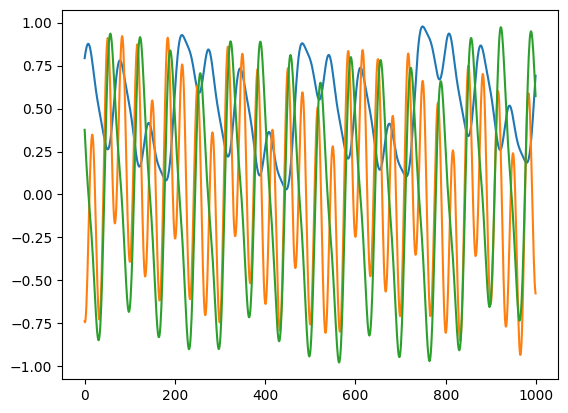

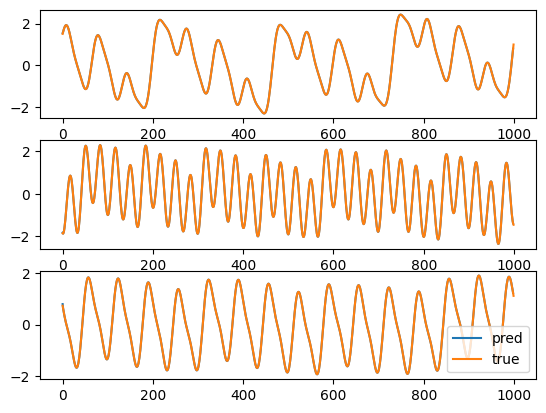

In [26]:
from neuromancer.psl.signals import sines
import numpy as np
references = sines(nsim=1000, d=sys.nx, min=sys.stats['X']['min'], max=sys.stats['X']['max'])
plt.plot(references)
test_data = {'R': torch.tensor(sys.normalize(references, key='X'), dtype=torch.float32).unsqueeze(0), 'xsys': sys.get_x0().reshape(1, 1, -1),
            'Time': (np.arange(1000)*sys.ts).reshape(1, 1000, 1)}
print({k: v.shape for k, v in test_data.items()})
test_system.nsteps=1000
with torch.no_grad():
    test_out = test_system(test_data)

print({k: v.shape for k, v in test_out.items()})
fix, ax = plt.subplots(nrows=3)
for v in range(3):
    ax[v].plot(test_out['xn'][0, 1:, v].detach().numpy(), label='pred')
    ax[v].plot(test_data['R'][0, :, v].detach().numpy(), label='true')
plt.legend()
plt.savefig('control.png')
